In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [64]:
from collections import Generator
from enum import Enum, auto
import pandas as pd
import seaborn as sns

## Simulation States

In [65]:
class HealthState(Enum):
    NORMAL = 1
    LOW_RISK_POLYP = 2
    HIGH_RISK_POLYP = 3
    CRC_STAGE1 = 5
    CRC_STAGE2 = 6
    CRC_STAGE3 = 7
    CRC_STAGE4 = 8
    DEATH_OTHER_CAUSES = 9
    DEATH_CRC = 10
    DEATH_FROM_SCREENING = 11
    TREATED_CRCSTAGE1 = 12
    TREATED_CRCSTAGE2 = 13
    TREATED_CRCSTAGE3 = 14
    TREATED_CRCSTAGE4 = 15


class Sex(Enum):
    MALE = 1
    FEMALE = 2


class Procedure(Enum):
    GFOBT = 1
    FIT = 2
    FIT_FS = 3
    COLONOSCOPY = 4
    POLYPECTOMY = 5
    BIOPSY = 6
    CRC_TREATMENT1 = 8
    CRC_TREATMENT2 = 9
    CRC_TREATMENT3 = 10
    CRC_TREATMENT4 = 11


## Parameters

In [66]:
health_prevalence_rate = {
    HealthState.NORMAL: 0.67227699,
    HealthState.LOW_RISK_POLYP: 0.16927146,
    HealthState.HIGH_RISK_POLYP: 0.11348882,
    HealthState.CRC_STAGE1: 0.00470540,
    HealthState.CRC_STAGE2: 0.01503115,
    HealthState.CRC_STAGE3: 0.01638177,
    HealthState.CRC_STAGE4: 0.00884441,
}


In [67]:
age_mortality_rate = {
    Sex.MALE: {
        54: 0.0076,
        59: 0.0089,
        64: 0.0102,
        69: 0.0106,
    },
    Sex.FEMALE: {
        54: 0.0054,
        59: 0.0065,
        64: 0.0077,
        69: 0.0089,
    }
}


In [68]:
health_state_transition_rate = {
    HealthState.NORMAL: {
        HealthState.LOW_RISK_POLYP: 0.0095,
        HealthState.NORMAL: 0.9905, 
    },
    HealthState.LOW_RISK_POLYP: {
        HealthState.HIGH_RISK_POLYP: 0.02,
        HealthState.LOW_RISK_POLYP: 0.98,
    },
    HealthState.HIGH_RISK_POLYP: {
        HealthState.CRC_STAGE1: 0.04,
        HealthState.CRC_STAGE2: 0.04,
        HealthState.HIGH_RISK_POLYP: 0.92,
    },
    HealthState.CRC_STAGE1: {
        HealthState.CRC_STAGE1: 0.7,
        HealthState.CRC_STAGE2: 0.3,
    },
    HealthState.CRC_STAGE2: {
        HealthState.DEATH_CRC: 0.61,
        HealthState.CRC_STAGE2: 0.2301,
        HealthState.CRC_STAGE3: 0.1599,
    },
    HealthState.CRC_STAGE3: {
        HealthState.DEATH_CRC: 0.61,
        HealthState.CRC_STAGE3: 0.0057,
        HealthState.CRC_STAGE4: 0.3843,
    },
    HealthState.CRC_STAGE4: {
        HealthState.DEATH_CRC: 0.5,
        HealthState.CRC_STAGE4:0.5,
    },
    # Treated CRC Mortality Rate
    HealthState.TREATED_CRCSTAGE1: {
        HealthState.TREATED_CRCSTAGE1: 1,
    },
    HealthState.TREATED_CRCSTAGE2: {
        HealthState.DEATH_CRC: 0.010,
        HealthState.TREATED_CRCSTAGE2: 0.99,
    },
    HealthState.TREATED_CRCSTAGE3: {
        HealthState.DEATH_CRC: 0.06,
        HealthState.TREATED_CRCSTAGE3: 0.94,
    },
    HealthState.TREATED_CRCSTAGE4: {
        HealthState.DEATH_CRC: 0.387,
        HealthState.TREATED_CRCSTAGE4: 0.613
    },
}


In [69]:
symptomatic_crc_detection_rate = {
    HealthState.CRC_STAGE1: 0.21,
    HealthState.CRC_STAGE2: 0.21,
    HealthState.CRC_STAGE3: 0.525,
    HealthState.CRC_STAGE4: 1
}


In [70]:
treatment_survival_rate = {
    HealthState.CRC_STAGE1: 0.95,
    HealthState.CRC_STAGE2: 0.79,
    HealthState.CRC_STAGE3: 0.56,
    HealthState.CRC_STAGE4: 0.0195,
}


In [71]:
utilities = {
    HealthState.NORMAL: 1,
    HealthState.LOW_RISK_POLYP: 0.8905,
    HealthState.HIGH_RISK_POLYP: 0.8295,
    HealthState.CRC_STAGE1: 0.7845,
    HealthState.CRC_STAGE2: 0.799,
    HealthState.CRC_STAGE3: 0.735,
    HealthState.CRC_STAGE4: 0.491,
    HealthState.TREATED_CRCSTAGE1: 0.7845,
    HealthState.TREATED_CRCSTAGE2: 0.799,
    HealthState.TREATED_CRCSTAGE3: 0.735,
    HealthState.TREATED_CRCSTAGE4: 0.491,
    HealthState.DEATH_OTHER_CAUSES: 0,
    HealthState.DEATH_CRC: 0,
    HealthState.DEATH_FROM_SCREENING: 0
}

procedure_costs = {
    Procedure.GFOBT: 190.8731,
    Procedure.FIT: 404.5658,
    Procedure.FIT_FS: 4432.0871,
    Procedure.COLONOSCOPY: 5366.965,
    Procedure.POLYPECTOMY: 6311.9301,
    Procedure.BIOPSY: 3450,
    Procedure.CRC_TREATMENT1: 235_000,
    Procedure.CRC_TREATMENT2: 320_000,
    Procedure.CRC_TREATMENT3: 320_000,
    Procedure.CRC_TREATMENT4: 0,
}

In [72]:
colonoscopy_positive_detection_rate = {
    HealthState.NORMAL: 0.05,
    HealthState.LOW_RISK_POLYP: 0.87,
    HealthState.HIGH_RISK_POLYP: 0.87,
    HealthState.CRC_STAGE1: 0.95,
    HealthState.CRC_STAGE2: 0.95,
    HealthState.CRC_STAGE3: 0.95,
    HealthState.CRC_STAGE4: 0.95
}

# biopsy_polyp_positive_detection_rate = {
#     HealthState.NORMAL: 0.3955,
#     HealthState.LOW_RISK_POLYP: 0.6045,
#     HealthState.HIGH_RISK_POLYP: 0.6045
# }

# Derived from Speci/Sensi/Prevalence using http://vassarstats.net/clin2.html
screening_modalities_positive_detection_rate = {
    Procedure.GFOBT: {
        HealthState.NORMAL: 0.1,
        HealthState.LOW_RISK_POLYP: 0.105,
        HealthState.HIGH_RISK_POLYP: 0.105,
        HealthState.CRC_STAGE1: 0.4,
        HealthState.CRC_STAGE2: 0.4,
        HealthState.CRC_STAGE3: 0.4,
        HealthState.CRC_STAGE4: 0.4
    },
    Procedure.FIT: {
        HealthState.NORMAL: 0.052,
        HealthState.LOW_RISK_POLYP: 0.1405,
        HealthState.HIGH_RISK_POLYP: 0.1405,
        HealthState.CRC_STAGE1: 0.7,
        HealthState.CRC_STAGE2: 0.7,
        HealthState.CRC_STAGE3: 0.7,
        HealthState.CRC_STAGE4: 0.7
    },
    Procedure.FIT_FS: {
        HealthState.NORMAL: 0.126,
        HealthState.LOW_RISK_POLYP: 0.7946,
        HealthState.HIGH_RISK_POLYP: 0.7946,
        HealthState.CRC_STAGE1: 0.971,
        HealthState.CRC_STAGE2: 0.971,
        HealthState.CRC_STAGE3: 0.971,
        HealthState.CRC_STAGE4: 0.971
    }
}

colonoscopy_mortality_rate = 0.000024
qaly_discounting = 0.03
cost_discounting = 0.03

## Simulation Classes and Functions

In [73]:
class RandomCVGenerator(Generator):
    def __init__(self, seed=427):
        self.seed_genX = np.random.RandomState(seed)

    def send(self, stub):
        randomX = self.seed_genX.rand()
        return randomX

    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration


In [74]:
def dict_to_cumulative(d):
    res = {}
    for k, v in d.items():
        res[v] = k
    return res


In [75]:
to_treated = {
    HealthState.CRC_STAGE1: HealthState.TREATED_CRCSTAGE1,
    HealthState.CRC_STAGE2: HealthState.TREATED_CRCSTAGE2,
    HealthState.CRC_STAGE3: HealthState.TREATED_CRCSTAGE3,
    HealthState.CRC_STAGE4: HealthState.TREATED_CRCSTAGE4
}

to_treatment = {
    HealthState.CRC_STAGE1: Procedure.CRC_TREATMENT1,
    HealthState.CRC_STAGE2: Procedure.CRC_TREATMENT2,
    HealthState.CRC_STAGE3: Procedure.CRC_TREATMENT3,
    HealthState.CRC_STAGE4: Procedure.CRC_TREATMENT4
}


In [76]:
class Individual(object):
    def __init__(self, state_prob, sex_prob, init_states_prob={}):
        self.state = self.init_health_state(state_prob, init_states_prob)
        self.age = 50
        self.procedures = np.array([])
        self.previous_states = np.array([])
        self.sex = Sex.MALE if sex_prob < 0.5 else Sex.FEMALE
        self.qalys = 0
        self.costs = 0
        self.years_til_colonoscopy = 0
        self.get_FOBT = True
        
        if self.state is None:
            raise Exception('No State!')

    def init_health_state(self, state_prob, states):
        if states == {}:
            states = {
                HealthState.NORMAL: 0.67227699,
                HealthState.LOW_RISK_POLYP: 0.16927146,
                HealthState.HIGH_RISK_POLYP: 0.11348882,
                HealthState.CRC_STAGE1: 0.00470540,
                HealthState.CRC_STAGE2: 0.01503115,
                HealthState.CRC_STAGE3: 0.01638177,
                HealthState.CRC_STAGE4: 0.00884441,
            }

        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(states)
        prev_k = 0
        sum_k = 0
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= state_prob < sum_k:
                return v
            prev_k += k

    @property
    def is_dead(self):
        if self.state == HealthState.DEATH_CRC or \
                self.state == HealthState.DEATH_FROM_SCREENING or \
                self.state == HealthState.DEATH_OTHER_CAUSES:
            return True
        else:
            return False

    @property
    def is_treated(self):
        if self.state == HealthState.TREATED_CRCSTAGE1 or \
                self.state == HealthState.TREATED_CRCSTAGE2 or \
                self.state == HealthState.TREATED_CRCSTAGE3 or \
                self.state == HealthState.TREATED_CRCSTAGE4:
            return True
        else:
            return False
        
    @property
    def has_cancer(self):
        if self.state == HealthState.CRC_STAGE1 or \
                self.state == HealthState.CRC_STAGE2 or \
                self.state == HealthState.CRC_STAGE3 or \
                self.state == HealthState.CRC_STAGE4:
            return True
        else:
            return False

    def __str__(self):
        return f'{self.age}: {self.state}'

    def __repr__(self):
        return self.__str__()


## Screening Strategies

In [177]:
def compute_other_mortality(individual):
    sex_mortality = age_mortality_rate[individual.sex]
    for k, v in sex_mortality.items():
        if individual.age > k:
            continue
        else:
            return v
    return


In [178]:
def no_screening(individual, num_gen):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Symptomatic Representation
    if symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        treatment_survival_prob = next(num_gen)
        if treatment_survival_prob <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, {individual.age: proc})
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    individual.age += 1

In [179]:
def colonoscopy_screening(individual, num_gen, compliance_rate_thresh):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Screening
    if next(num_gen) <= compliance_rate_thresh and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, {individual.age: Procedure.COLONOSCOPY})
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, {individual.age: Procedure.BIOPSY})
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, {individual.age: Procedure.POLYPECTOMY})
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL
                    individual.years_til_colonoscopy = 1

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, {individual.age: proc})
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                        
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                        individual.years_til_colonoscopy = 1

                else: # Normal State but had colonoscopy
                    individual.years_til_colonoscopy = 10
                    # Copy paste sadness
                    ht_rate = health_state_transition_rate[individual.state]
                    # We just transpose the health states and probs
                    # to compare with the random number generated
                    states_conv = dict_to_cumulative(ht_rate)
                    prev_k = 0
                    sum_k = 0
                    htr_prob = next(num_gen)
                    for k, v in states_conv.items():
                        sum_k += k
                        if prev_k <= htr_prob < sum_k:
                            individual.state = v
                        prev_k += k

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, {individual.age: proc})
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1
    individual.age += 1

In [180]:
def FOBT_screening(individual, num_gen, compliance_rate_thresh1, compliance_rate_thresh2, screening_modality):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    if next(num_gen) <= compliance_rate_thresh1 and individual.get_FOBT and not individual.is_treated:

        individual.procedures = np.append(
            individual.procedures, {individual.age: screening_modality})
        individual.costs += procedure_costs[screening_modality] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        fobt_detection_rate = screening_modalities_positive_detection_rate[
            screening_modality][individual.state]
        if next(num_gen) <= fobt_detection_rate:
            # Colonoscopy Screening
            if next(num_gen) <= compliance_rate_thresh2:
                # Get colonoscopy
                individual.procedures = np.append(
                    individual.procedures, {individual.age: Procedure.COLONOSCOPY})
                individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                # Probability of bleeding/perforation death
                if next(num_gen) <= colonoscopy_mortality_rate:
                    individual.state = HealthState.DEATH_FROM_SCREENING

                else:
                    if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                        # Get Biopsy
                        individual.procedures = np.append(
                            individual.procedures, {individual.age: Procedure.BIOPSY})
                        individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                        if individual.state == HealthState.LOW_RISK_POLYP or \
                                individual.state == HealthState.HIGH_RISK_POLYP:

                            # Get Polypectomy
                            individual.procedures = np.append(
                                individual.procedures, {individual.age: Procedure.POLYPECTOMY})
                            individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                            individual.state = HealthState.NORMAL
                            individual.get_FOBT = True
                            individual.years_til_colonoscopy = 1

                        elif individual.has_cancer:

                            # Copy paste sadness
                            treatment_survival_prob = next(num_gen)
                            if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                                # Get the procedure for treatment
                                proc = to_treatment[individual.state]
                                individual.procedures = np.append(
                                    individual.procedures, {individual.age: proc})
                                individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                                # Convert to treated
                                individual.state = to_treated[individual.state]
                            else:
                                # Copy paste sadness
                                ht_rate = health_state_transition_rate[individual.state]
                                # We just transpose the health states and probs
                                # to compare with the random number generated
                                states_conv = dict_to_cumulative(ht_rate)
                                prev_k = 0
                                sum_k = 0
                                htr_prob = next(num_gen)
                                for k, v in states_conv.items():
                                    sum_k += k
                                    if prev_k <= htr_prob < sum_k:
                                        individual.state = v
                                    prev_k += k
                        else:
                            # Normal State but had colonoscopy
                            individual.years_til_colonoscopy = 10
                            # Copy paste sadness
                            ht_rate = health_state_transition_rate[individual.state]
                            # We just transpose the health states and probs
                            # to compare with the random number generated
                            states_conv = dict_to_cumulative(ht_rate)
                            prev_k = 0
                            sum_k = 0
                            htr_prob = next(num_gen)
                            for k, v in states_conv.items():
                                sum_k += k
                                if prev_k <= htr_prob < sum_k:
                                    individual.state = v
                                prev_k += k
                            individual.years_til_colonoscopy = 1
                            individual.get_FOBT = True

                    else:
                        individual.years_til_colonoscopy = 10
                        individual.get_FOBT = False

    # Colonoscopy Screening
    elif next(num_gen) <= compliance_rate_thresh2 and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated and not individual.get_FOBT:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, {individual.age: Procedure.COLONOSCOPY})
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, {individual.age: Procedure.BIOPSY})
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, {individual.age: Procedure.POLYPECTOMY})
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL
                    individual.get_FOBT = True

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, {individual.age: proc})
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                else:
                    # Normal State but had colonoscopy
                    individual.years_til_colonoscopy = 10
                    # Copy paste sadness
                    ht_rate = health_state_transition_rate[individual.state]
                    # We just transpose the health states and probs
                    # to compare with the random number generated
                    states_conv = dict_to_cumulative(ht_rate)
                    prev_k = 0
                    sum_k = 0
                    htr_prob = next(num_gen)
                    for k, v in states_conv.items():
                        sum_k += k
                        if prev_k <= htr_prob < sum_k:
                            individual.state = v
                        prev_k += k
                    individual.years_til_colonoscopy = 1
                    individual.get_FOBT = True

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, {individual.age: proc})
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1
    individual.age += 1

In [181]:
def to_df(individuals):
    df = pd.DataFrame()
    df['life_years'] = np.array(
        [len(i.previous_states) if not i.is_dead else len(i.previous_states) + 1 for i in individuals])
    df['cost'] = np.array([i.costs for i in individuals])
    df['qalys'] = np.array([i.qalys for i in individuals])
    return df


## Test Bed for No Screening

In [82]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals_noscreening = np.array([Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen), 
                          init_states_prob=health_prevalence_rate)
               for _ in range(individual_count)])

(array([67205., 17000., 11479.,     0.,     0.,   434.,     0.,  1438.,
         1622.,   822.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

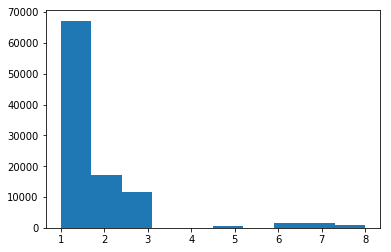

In [83]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals_noscreening]))

In [84]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals_noscreening:
        no_screening(i, sim_gen)

(array([6.4996e+04, 8.8600e+03, 0.0000e+00, 3.8300e+02, 2.3000e+01,
        1.2130e+03, 1.8801e+04, 0.0000e+00, 3.5200e+02, 5.3720e+03]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 10 Patch objects>)

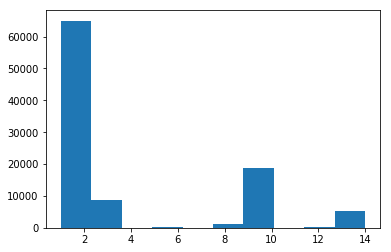

In [85]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals_noscreening]))

In [86]:
prev_states = np.array([i.previous_states[-1].value for i in individuals_noscreening if i.state.value == 10])
prev_states.shape


(4156,)

(array([2266.,  973.,    0.,    0.,    0.,    0.,    0.,    0.,  583.,
         334.]),
 array([ 6. ,  6.8,  7.6,  8.4,  9.2, 10. , 10.8, 11.6, 12.4, 13.2, 14. ]),
 <a list of 10 Patch objects>)

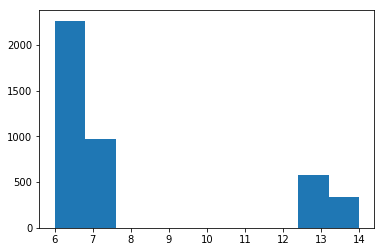

In [87]:
hist(prev_states)

In [88]:
QALYs = sum(np.array([i.qalys for i in individuals_noscreening]))
costs = sum(np.array([i.costs for i in individuals_noscreening]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1646952.6029126213
Costs: 2236296116.504854
QALY Diff: 0.8234763014563107


(array([ 662.,    0.,  917.,    0.,    0.,    0.,  352.,    0., 5155.,
         217.]),
 array([ 9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. ]),
 <a list of 10 Patch objects>)

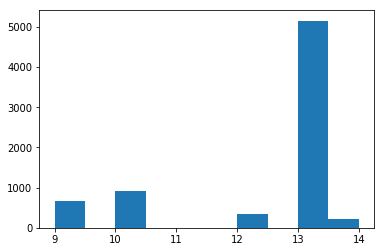

In [89]:
hist(
    np.array([i.state.value for i in individuals_noscreening if len(i.procedures) == 1]))


## Test Bed for Colonoscopy Screening

In [90]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals_colonoscopy = np.array([Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)])

(array([67205., 17000., 11479.,     0.,     0.,   434.,     0.,  1438.,
         1622.,   822.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

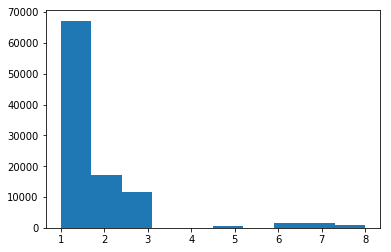

In [91]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals_colonoscopy]))

In [92]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals_colonoscopy:
        colonoscopy_screening(i, sim_gen, 0.725)

(array([8.1172e+04, 6.4900e+02, 0.0000e+00, 2.5000e+01, 2.0000e+00,
        1.4285e+04, 1.9620e+03, 3.6800e+02, 1.3070e+03, 2.3000e+02]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

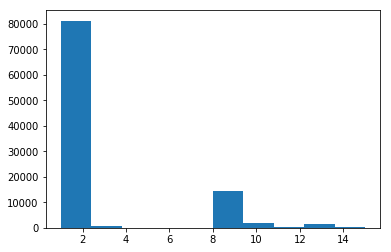

In [93]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals_colonoscopy]))

In [94]:
prev_states = np.array([i.previous_states[-1].value for i in individuals_colonoscopy if i.state.value == 10])
prev_states.shape


(1962,)

(array([450., 589.,   0.,   0.,   0.,   0.,   0., 233., 498., 192.]),
 array([ 6. ,  6.9,  7.8,  8.7,  9.6, 10.5, 11.4, 12.3, 13.2, 14.1, 15. ]),
 <a list of 10 Patch objects>)

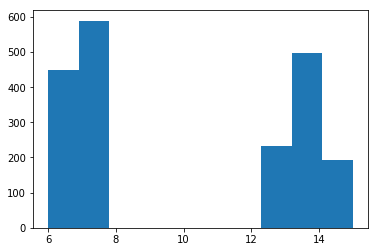

In [95]:
hist(prev_states)

In [96]:
QALYs = sum(np.array([i.qalys for i in individuals_colonoscopy]))
costs = sum(np.array([i.costs for i in individuals_colonoscopy]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1757189.4922330098
Costs: 2481981734.4365044
QALY Diff: 0.8785947461165049


(array([5., 3., 3., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 8. ,  8.7,  9.4, 10.1, 10.8, 11.5, 12.2, 12.9, 13.6, 14.3, 15. ]),
 <a list of 10 Patch objects>)

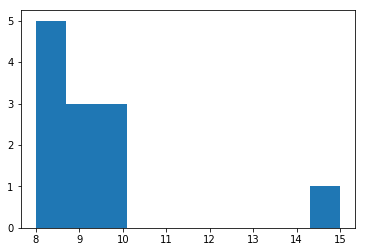

In [97]:
hist(
    np.array([i.state.value for i in individuals_colonoscopy if len(i.procedures) == 14]))


## Test Bed for G-FOBT Screening

In [98]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals_gfobt = np.array([Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)])

(array([67205., 17000., 11479.,     0.,     0.,   434.,     0.,  1438.,
         1622.,   822.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

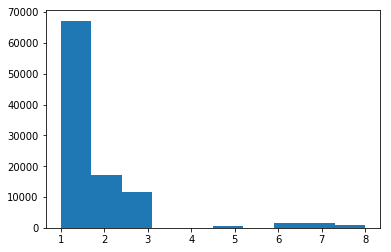

In [99]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals_gfobt]))

In [100]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals_gfobt:
        FOBT_screening(i, sim_gen, 0.65, 0.8, Procedure.GFOBT)

(array([8.1658e+04, 3.8290e+03, 0.0000e+00, 1.0600e+02, 9.0000e+00,
        9.4710e+03, 2.2770e+03, 3.4300e+02, 2.1050e+03, 2.0200e+02]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

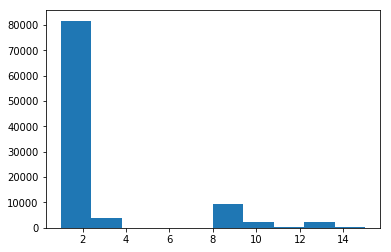

In [101]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals_gfobt]))

In [102]:
prev_states = np.array([i.previous_states[-1].value for i in individuals_gfobt if i.state.value == 11])
prev_states.shape


(4,)

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

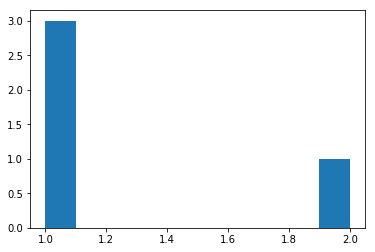

In [103]:
hist(prev_states)

In [104]:
QALYs = sum(np.array([i.qalys for i in individuals_gfobt]))
costs = sum(np.array([i.costs for i in individuals_gfobt]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1766505.4339805825
Costs: 2059372313.6324267
QALY Diff: 0.8832527169902913


(array([7.143e+03, 5.270e+02, 0.000e+00, 1.600e+01, 2.000e+00, 1.920e+02,
        8.000e+00, 0.000e+00, 4.800e+01, 3.000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

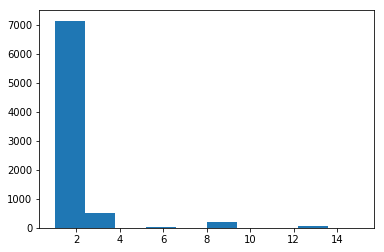

In [105]:
hist(
    np.array([i.state.value for i in individuals_gfobt if len(i.procedures) == 14]))


## Test Bed for FIT Screening

In [106]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals_FIT = np.array([Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)])

(array([67205., 17000., 11479.,     0.,     0.,   434.,     0.,  1438.,
         1622.,   822.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

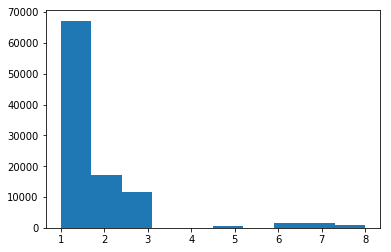

In [107]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals_FIT]))

In [108]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals_FIT:
        FOBT_screening(i, sim_gen, 0.65, 0.8, Procedure.FIT)

(array([8.411e+04, 2.741e+03, 0.000e+00, 7.300e+01, 2.000e+00, 8.364e+03,
        2.237e+03, 3.360e+02, 1.940e+03, 1.970e+02]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

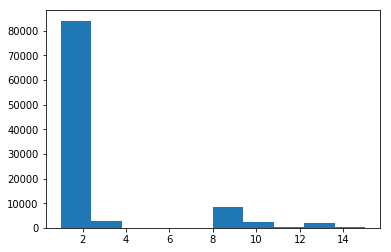

In [109]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals_FIT]))

In [110]:
prev_states = np.array([i.previous_states[-1].value for i in individuals_FIT if i.state.value == 11])
prev_states.shape


(3,)

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

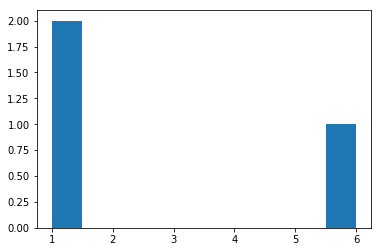

In [111]:
hist(prev_states)

In [112]:
QALYs = sum(np.array([i.qalys for i in individuals_FIT]))
costs = sum(np.array([i.costs for i in individuals_FIT]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1781578.051456311
Costs: 2167500657.683981
QALY Diff: 0.8907890257281555


(array([9.626e+03, 3.530e+02, 0.000e+00, 8.000e+00, 0.000e+00, 1.520e+02,
        1.500e+01, 0.000e+00, 2.000e+01, 2.000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

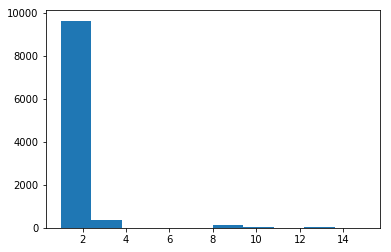

In [113]:
hist(
    np.array([i.state.value for i in individuals_FIT if len(i.procedures) == 14]))


## Test Bed for FIT+FS Screening

In [114]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals_FITFS = np.array([Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)])

(array([67205., 17000., 11479.,     0.,     0.,   434.,     0.,  1438.,
         1622.,   822.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

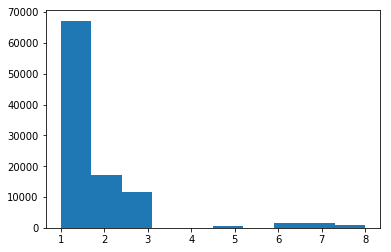

In [115]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals_FITFS]))

In [116]:
import multiprocessing as mp

# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals_FITFS:
        FOBT_screening(i, sim_gen, 0.8, 0.996, Procedure.FIT_FS)        
#     processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]


(array([8.5665e+04, 3.5200e+02, 0.0000e+00, 1.2000e+01, 0.0000e+00,
        1.0170e+04, 1.9390e+03, 3.5800e+02, 1.2450e+03, 2.5900e+02]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

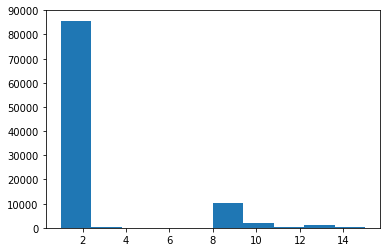

In [117]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals_FITFS]))

In [118]:
prev_states = np.array([i.previous_states[-1].value for i in individuals_FITFS if i.state.value == 11])
prev_states.shape


(1,)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

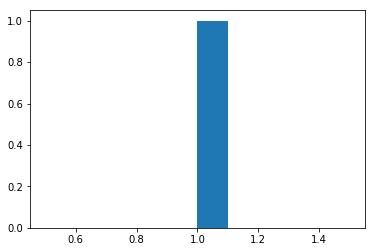

In [119]:
hist(prev_states)

In [120]:
QALYs = sum(np.array([i.qalys for i in individuals_FITFS]))
costs = sum(np.array([i.costs for i in individuals_FITFS]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1805840.0038834955
Costs: 5399584136.800969
QALY Diff: 0.9029200019417477


(array([4.925e+03, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.860e+02, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <a list of 10 Patch objects>)

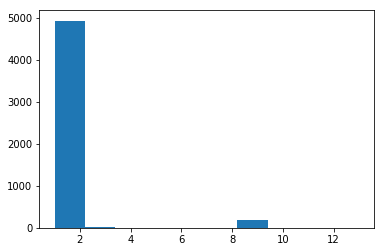

In [121]:
hist(
    np.array([i.state.value for i in individuals_FITFS if len(i.procedures) == 14]))


(array([ 1195.,   664.,   854.,   980.,  1134.,  1109.,  1178.,  1301.,
         1439., 90146.]),
 array([51. , 52.9, 54.8, 56.7, 58.6, 60.5, 62.4, 64.3, 66.2, 68.1, 70. ]),
 <a list of 10 Patch objects>)

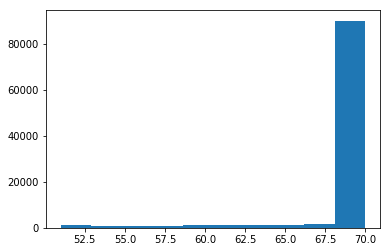

In [122]:
hist(
    np.array([i.age for i in individuals_FITFS]))

In [124]:
%store individuals_noscreening
%store individuals_gfobt
%store individuals_FIT
%store individuals_FITFS

Stored 'individuals_noscreening' (ndarray)
Stored 'individuals_gfobt' (ndarray)
Stored 'individuals_FIT' (ndarray)
Stored 'individuals_FITFS' (ndarray)


## For Budget Impact Analysis

### GFOBT

In [182]:
individuals_compliance_rates_GFOBT = np.array([])

# Simulate!
for compliance_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate, 0.8, Procedure.GFOBT)
    individuals_compliance_rates_GFOBT = np.append(individuals_compliance_rates_GFOBT, 
                                                   {compliance_rate: individuals})
    
    print(f'Sim {compliance_rate}')

Sim 0.1
Sim 0.2
Sim 0.3
Sim 0.4
Sim 0.5


In [225]:
for e, r in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    indiv_comp_rate = individuals_compliance_rates_GFOBT[e][r]
    gfobt_count = 0
    colonoscopy_count = 0
    for x in indiv_comp_rate:
        for i in x.procedures:
            if list(i.keys())[0] == 50:
                if i[50] == Procedure.GFOBT:
    #                 print(f'{x.previous_states[0]} : ')
                    gfobt_count += 1
                elif i[50] == Procedure.COLONOSCOPY:
                    colonoscopy_count += 1
    print(f'{r} - {gfobt_count} - {colonoscopy_count}')

0.1 - 9984 - 904
0.2 - 20267 - 1823
0.3 - 30155 - 2660
0.4 - 39852 - 3658
0.5 - 49828 - 4608


In [226]:
individuals_compliance_rates_FIT = np.array([])

# Simulate!
for compliance_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate, 0.8, Procedure.FIT)
    individuals_compliance_rates_FIT = np.append(individuals_compliance_rates_FIT, {compliance_rate: individuals})
    
    print(f'Sim {compliance_rate}')

Sim 0.1
Sim 0.2
Sim 0.3
Sim 0.4
Sim 0.5


In [227]:
for e, r in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    indiv_comp_rate = individuals_compliance_rates_FIT[e][r]
    fit_count = 0
    colonoscopy_count = 0
    for x in indiv_comp_rate:
        for i in x.procedures:
            if list(i.keys())[0] == 50:
                if i[50] == Procedure.FIT:
    #                 print(f'{x.previous_states[0]} : ')
                    fit_count += 1
                elif i[50] == Procedure.COLONOSCOPY:
                    colonoscopy_count += 1
    print(f'{r} - {fit_count} - {colonoscopy_count}')

0.1 - 9985 - 857
0.2 - 20186 - 1657
0.3 - 29964 - 2541
0.4 - 39900 - 3386
0.5 - 49940 - 4161


In [128]:
gfobt_procs = pd.DataFrame()
gfobt_procs['first'] = [i.procedures[0].name if len(i.procedures) > 0 else 'NONE' for i in individuals_gfobt]
gfobt_procs['second'] = [i.procedures[1].name if len(i.procedures) > 1 else 'NONE' for i in individuals_gfobt]

In [144]:
gfobt_procs[gfobt_procs['second'] == 'COLONOSCOPY'].count()['second'] / 100_000 * 11_697_514

1019789.2705199999

In [139]:
fit_procs = pd.DataFrame()
fit_procs['first'] = [i.procedures[0].name if len(i.procedures) > 0 else 'NONE' for i in individuals_FIT]
fit_procs['second'] = [i.procedures[1].name if len(i.procedures) > 1 else 'NONE' for i in individuals_FIT]

In [145]:
fit_procs[fit_procs['second'] == 'COLONOSCOPY'].count()['second'] / 100_000 *  11_697_514

926209.15852

## Sensitivity Analysis for GFOBT Compliance Rates

In [228]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])
individual_sensitivity_icers = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate/100, 1, Procedure.GFOBT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys, 
                                           sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs, 
                                           sum(np.array([i.costs for i in individuals])))
    
    print(f'Sim {compliance_rate} - '\
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '\
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1647127.45631068 - Costs: 2229120713.225242
Sim 2 - QALYs: 1650990.677184466 - Costs: 2205254832.875728
Sim 3 - QALYs: 1653287.9218446605 - Costs: 2214100644.441845
Sim 4 - QALYs: 1655097.900485437 - Costs: 2223567762.2891264
Sim 5 - QALYs: 1659259.5184466022 - Costs: 2182135952.955048
Sim 6 - QALYs: 1662254.0043689322 - Costs: 2173593416.1263103
Sim 7 - QALYs: 1662276.246601942 - Costs: 2191771300.402136
Sim 8 - QALYs: 1663323.7432038833 - Costs: 2167163960.97466
Sim 9 - QALYs: 1667243.9975728157 - Costs: 2151613375.634369
Sim 10 - QALYs: 1670180.5427184466 - Costs: 2161869522.7183495
Sim 11 - QALYs: 1671645.4291262138 - Costs: 2192042866.3357277
Sim 12 - QALYs: 1675358.8854368932 - Costs: 2178308477.0512614
Sim 13 - QALYs: 1676886.1111650486 - Costs: 2180426542.58398
Sim 14 - QALYs: 1678429.4354368933 - Costs: 2157761691.8990293
Sim 15 - QALYs: 1680377.882524272 - Costs: 2149706670.43
Sim 16 - QALYs: 1683438.8213592237 - Costs: 2159706976.3928156
Sim 17 - QALYs: 168473

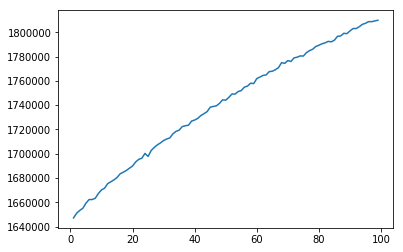

In [229]:
plot(range(1,100), individual_sensitivity_qalys)

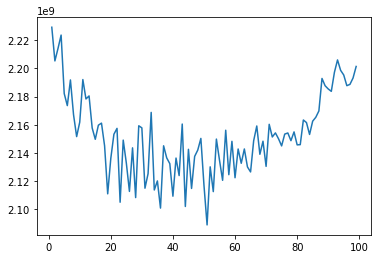

In [230]:
plot(range(1,100), individual_sensitivity_costs)

In [231]:
from statsmodels.tsa.filters.hp_filter import hpfilter

/home/hadrian/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


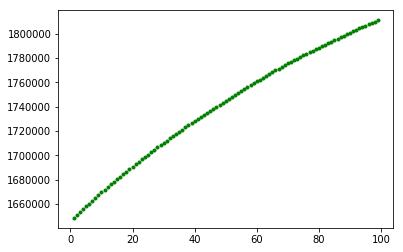

In [249]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*2**2 )[1],'g.')


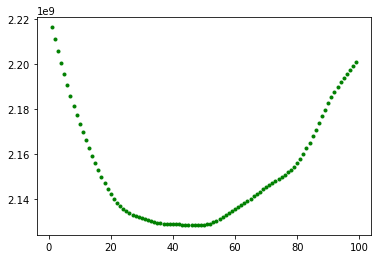

In [248]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*2**2)[1], 'g.')

## Sensitivity Analysis for FIT Compliance Rates

In [250]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate/100, 1, Procedure.FIT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys,
                                             sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs,
                                             sum(np.array([i.costs for i in individuals])))

    print(f'Sim {compliance_rate} - '
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1650192.2048543694 - Costs: 2195419729.102913
Sim 2 - QALYs: 1652282.2199029129 - Costs: 2221036361.4008737
Sim 3 - QALYs: 1654898.1179611653 - Costs: 2193105361.3089323
Sim 4 - QALYs: 1656186.469417476 - Costs: 2184255180.629709
Sim 5 - QALYs: 1657785.1422330101 - Costs: 2190366195.696408
Sim 6 - QALYs: 1663234.0577669903 - Costs: 2224735950.6843686
Sim 7 - QALYs: 1665953.5800970877 - Costs: 2199050380.140971
Sim 8 - QALYs: 1667159.4286407768 - Costs: 2186330579.6583495
Sim 9 - QALYs: 1669871.1519417476 - Costs: 2178362564.491359
Sim 10 - QALYs: 1671803.0082524272 - Costs: 2183566602.655631
Sim 11 - QALYs: 1674546.3650485438 - Costs: 2154536432.8941746
Sim 12 - QALYs: 1677984.3223300972 - Costs: 2178374767.71466
Sim 13 - QALYs: 1681206.8121359223 - Costs: 2163167080.0518446
Sim 14 - QALYs: 1682203.3747572817 - Costs: 2151519136.0802913
Sim 15 - QALYs: 1684522.7548543692 - Costs: 2180154193.6174755
Sim 16 - QALYs: 1686551.2611650492 - Costs: 2194001048.9021363
Sim 17 - Q

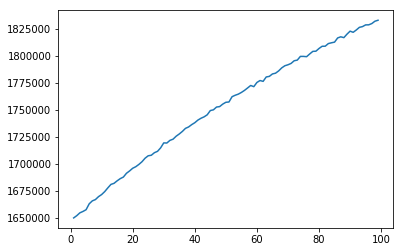

In [251]:
plot(range(1,100), individual_sensitivity_qalys)

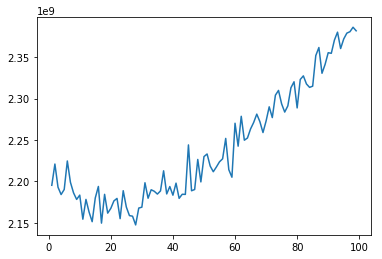

In [252]:
plot(range(1,100), individual_sensitivity_costs)

In [253]:
from statsmodels.tsa.filters.hp_filter import hpfilter

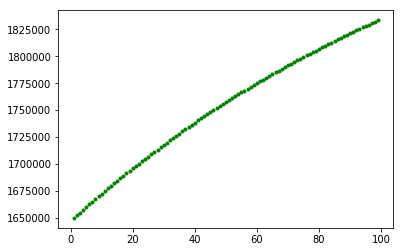

In [256]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*2**2)[1], 'g.')

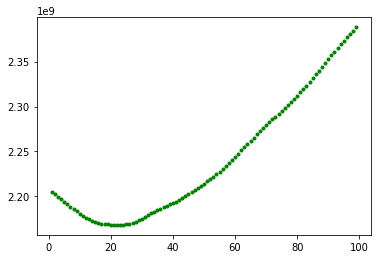

In [257]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*2**2)[1], 'g.')

## Sensitivity Analysis for Colonoscopy Compliance Rates

In [258]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            colonoscopy_screening(i, sim_gen, compliance_rate/100)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys, 
                                           sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs, 
                                           sum(np.array([i.costs for i in individuals])))
    
    print(f'Sim {compliance_rate} - '\
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '\
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1655149.9553398057 - Costs: 2211030438.207475
Sim 2 - QALYs: 1662041.3480582524 - Costs: 2226783212.055437
Sim 3 - QALYs: 1666926.2024271847 - Costs: 2222827640.649126
Sim 4 - QALYs: 1675192.860194175 - Costs: 2238927265.0533977
Sim 5 - QALYs: 1680783.879126214 - Costs: 2244915259.957379
Sim 6 - QALYs: 1686856.5019417475 - Costs: 2278869544.7266016
Sim 7 - QALYs: 1691577.8927184464 - Costs: 2291126292.970291
Sim 8 - QALYs: 1694493.5499999998 - Costs: 2269027828.410291
Sim 9 - QALYs: 1698384.6757281553 - Costs: 2271137840.0825243
Sim 10 - QALYs: 1704151.1203883495 - Costs: 2264706230.7118444
Sim 11 - QALYs: 1705892.4902912623 - Costs: 2290467128.1659226
Sim 12 - QALYs: 1710185.81407767 - Costs: 2298330312.401553
Sim 13 - QALYs: 1713658.4004854371 - Costs: 2309800863.1808743
Sim 14 - QALYs: 1714609.769417476 - Costs: 2275328416.3715534
Sim 15 - QALYs: 1717355.282038835 - Costs: 2327613333.0299997
Sim 16 - QALYs: 1717923.845145631 - Costs: 2339097076.8938837
Sim 17 - QALYs:

## Sensitivity Analysis for FIT Compliance Rates

In [263]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, 0.65, compliance_rate/100, Procedure.FIT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys,
                                             sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs,
                                             sum(np.array([i.costs for i in individuals])))

    print(f'Sim {compliance_rate} - '
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1759250.0009708747 - Costs: 1587485879.8218446
Sim 2 - QALYs: 1759417.1339805827 - Costs: 1586351104.2812622
Sim 3 - QALYs: 1758968.5169902917 - Costs: 1610399793.3924272
Sim 4 - QALYs: 1759363.5291262139 - Costs: 1638352925.9057283
Sim 5 - QALYs: 1761080.1276699032 - Costs: 1639798588.3197086
Sim 6 - QALYs: 1761242.4791262138 - Costs: 1646719601.0187378
Sim 7 - QALYs: 1762201.1519417479 - Costs: 1683828630.1394176
Sim 8 - QALYs: 1763189.5242718447 - Costs: 1700973171.8621356
Sim 9 - QALYs: 1761556.1262135927 - Costs: 1723743408.6010675
Sim 10 - QALYs: 1762329.7898058256 - Costs: 1701326596.4815533
Sim 11 - QALYs: 1763693.7504854372 - Costs: 1712919272.6958249
Sim 12 - QALYs: 1763976.8577669903 - Costs: 1753497676.927864
Sim 13 - QALYs: 1764716.2174757281 - Costs: 1766265355.5346606
Sim 14 - QALYs: 1763779.6339805827 - Costs: 1763038827.0859222
Sim 15 - QALYs: 1765501.9373786412 - Costs: 1768963346.7302914
Sim 16 - QALYs: 1764039.0902912624 - Costs: 1776807374.073495
Sim

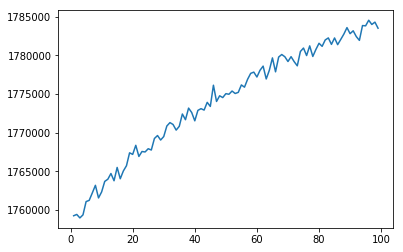

In [264]:
plot(range(1,100), individual_sensitivity_qalys)

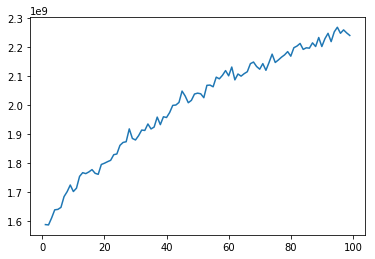

In [265]:
plot(range(1,100), individual_sensitivity_costs)

In [266]:
from statsmodels.tsa.filters.hp_filter import hpfilter

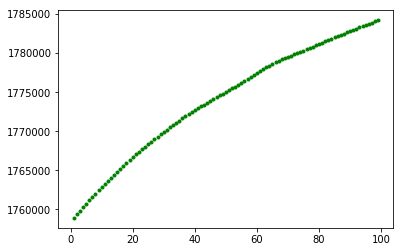

In [267]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*2**2)[1], 'g.')

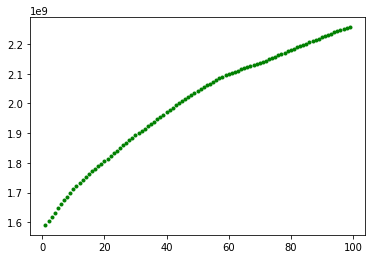

In [268]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*2**2)[1], 'g.')

## Sensitivity Analysis for GFOBT Follow-up Colonoscopy Compliance Rates

In [269]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, 0.65, compliance_rate/100, Procedure.GFOBT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys,
                                             sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs,
                                             sum(np.array([i.costs for i in individuals])))

    print(f'Sim {compliance_rate} - '
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1759474.4621359226 - Costs: 1339221100.1694174
Sim 2 - QALYs: 1759837.1402912622 - Costs: 1338647604.9822328
Sim 3 - QALYs: 1758937.6218446603 - Costs: 1356683039.133107
Sim 4 - QALYs: 1759617.7621359227 - Costs: 1387168024.2521358
Sim 5 - QALYs: 1759326.5533980585 - Costs: 1379073479.643107
Sim 6 - QALYs: 1758945.5883495149 - Costs: 1383209186.6846602
Sim 7 - QALYs: 1759999.4485436892 - Costs: 1400469918.2704852
Sim 8 - QALYs: 1760045.3776699032 - Costs: 1405383690.3306794
Sim 9 - QALYs: 1759979.1038834956 - Costs: 1413167197.057961
Sim 10 - QALYs: 1760477.9500000004 - Costs: 1456733610.3005824
Sim 11 - QALYs: 1760917.388834952 - Costs: 1483867540.8433979
Sim 12 - QALYs: 1761542.4665048546 - Costs: 1457677871.747961
Sim 13 - QALYs: 1760799.638834952 - Costs: 1449447101.2437866
Sim 14 - QALYs: 1760109.291747573 - Costs: 1512989402.3994174
Sim 15 - QALYs: 1761357.4315533985 - Costs: 1507405902.2366018
Sim 16 - QALYs: 1762102.139805826 - Costs: 1513907289.2516506
Sim 17 - 

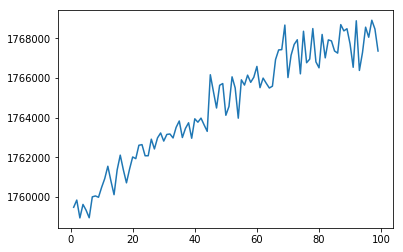

In [270]:
plot(range(1,100), individual_sensitivity_qalys)

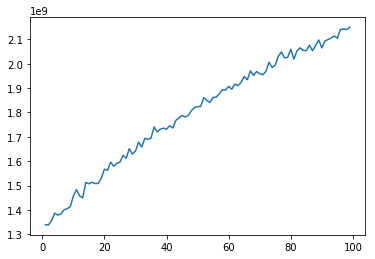

In [271]:
plot(range(1,100), individual_sensitivity_costs)

In [272]:
from statsmodels.tsa.filters.hp_filter import hpfilter

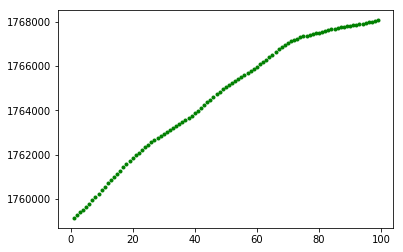

In [273]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*2**2)[1], 'g.')

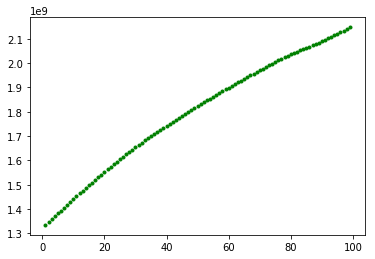

In [274]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*2**2)[1], 'g.')

## Averted Zben cases